# Métodos de Diferencias Temporales (TD)

En este notebook exploraremos métodos de diferencias temporales, una familia de técnicas en Reinforcement Learning (RL) que permiten aprender a través de la experiencia sin necesidad de conocer un modelo del entorno. En particular, abordaremos dos algoritmos fundamentales:

- **Sarsa (on-policy):** Un método de control en el que la política utilizada para seleccionar acciones es la misma que se evalúa y mejora.
- **Q-Learning (off-policy):** Un método que aprende la función de valor óptima de manera independiente de la política seguida, permitiendo una mayor flexibilidad en la exploración.

La implementación y el análisis se basan en el capítulo 6 del libro de Sutton y Barto, uno de los textos de referencia en el campo del aprendizaje por refuerzo.

## Objetivos

- **Implementación del algoritmo Q-Learning:** Desarrollar y ajustar el algoritmo para estimar la función de valor óptima.
- **Implementación del algoritmo Sarsa:** Desarrollar la versión on-policy para la estimación y mejora de la política.
- **Comparación de desempeño:** Evaluar y comparar el desempeño de ambos algoritmos en el entorno definido, midiendo el tiempo (o cantidad de episodios) necesario para alcanzar el objetivo de manera promedio.
- **Experimento en Cliff Walking:** Realizar el experimento clásico de Cliff Walking descrito en el libro para corroborar los conceptos y resultados presentados.


## Descripción del Ambiente: MountainCar

El entorno [**MountainCar**](https://gymnasium.farama.org/environments/classic_control/mountain_car/) es un clásico problema de control utilizado en el ámbito del Reinforcement Learning. En este escenario, un automóvil se encuentra atrapado en un valle estrecho entre dos colinas y debe aprender a alcanzar la cima de la montaña de la derecha. Debido a las limitaciones físicas, el coche no puede simplemente acelerar de forma continua hacia la cima; en cambio, debe aprovechar la inercia y la gravedad para acumular suficiente impulso.

**Espacio de Estados**

El estado del entorno se define mediante dos variables continuas:
- **Posición:** Indica la ubicación actual del automóvil sobre la pista, con un rango aproximado de \[-0.6, 0.4\].
- **Velocidad:** Representa la velocidad del automóvil, y comienza siempre en 0.

**Acciones Disponibles**

El agente dispone de tres acciones discretas:
- **[0] Empujar a la izquierda:** Aplica una fuerza que impulsa el coche hacia la izquierda.
- **[1] No hacer nada:** No se aplica ninguna fuerza, permitiendo que la dinámica natural del coche influya en el movimiento.
- **[2] Empujar a la derecha:** Aplica una fuerza que impulsa el coche hacia la derecha.

**Mecánica y Dinámica del Problema**

El desafío principal no radica únicamente en acelerar hacia la derecha. Debido a la gravedad y las limitaciones del motor del coche, para lograr alcanzar la cima de la montaña es necesario **aprovechar la inercia**. Esto implica que, en muchos casos, el coche debe moverse hacia la izquierda para ganar impulso y luego aprovechar esa energía para impulsarse con mayor fuerza hacia la derecha, logrando finalmente superar la pendiente.

**Función de Recompensa**

En cada paso del tiempo, el agente recibe una recompensa constante de **-1**. Esta penalización por cada paso incentiva al agente a encontrar la estrategia óptima que le permita alcanzar la cima de la montaña en la menor cantidad de pasos posible. Al llegar a la meta (generalmente cuando la posición del coche alcanza o supera un valor umbral, 0.5), el episodio se termina.


![MountainCar](https://gymnasium.farama.org/_images/mountain_car.gif)


In [1]:
import gymnasium as gym
from gymnasium.utils.play import play
from gymnasium.wrappers import RecordVideo, TransformObservation
from gymnasium import spaces
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from Utils import plot_rewards, plot_epsilon
from collections import defaultdict
%matplotlib inline

In [2]:
def get_env(record_video=False, record_every=1, folder="./videos" ):
    """
    Create the MountainCar environment with optional video recording and statistics.
    Args:
        record_video (bool): Whether to record video of the episodes.
        record_every (int): Frequency of recording episodes.
        folder (str): Folder to save the recorded videos.
    Returns:
        env (gym.Env): The MountainCar environment.
        
    See also:
        https://gymnasium.farama.org/introduction/record_agent/
    """
    # Initialise the environment
    env = gym.make("MountainCar-v0", render_mode="rgb_array")

    if record_video:
        env = RecordVideo(env, video_folder=folder, name_prefix="MountainCar",
                    episode_trigger=lambda x: x % record_every == 0)
    
    return env

In [3]:
env = get_env(record_video=True, record_every=1, folder="./videos/random_actions")

for episode_num in range(5):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated

## Modelando el Ambiente con Q-Learning y Sarsa

Tanto Q-Learning como Sarsa son algoritmos basados en **métodos tabulares**, lo que significa que requieren un espacio de estados discreto para almacenar y actualizar los valores Q asociados a cada acción en cada estado. Sin embargo, el ambiente MountainCar **presenta estados continuos**, ya que se define a partir de variables como la posición y la velocidad, lo que plantea ciertos desafíos.

Debido a que estos valores pueden tomar infinitos valores posibles, resulta inviable utilizar una representación tabular directa para el aprendizaje.

### Discretización de Estados

¿Cómo se puede aplicar Q-Learning y Sarsa en un entorno con estados continuos? -> Discretización

Para aplicar Q-Learning y Sarsa en un entorno con estados continuos, se recurre a la **discretización**. Esto consiste en dividir cada dimensión del estado en un número finito de intervalos (o "bins"), de modo que:

- **Conversión a Estados Discretos:** Cada par de valores (posición, velocidad) se asigna a un "bin" o estado discreto, permitiendo indexar una tabla Q.
- **Reducción de la Complejidad:** Al transformar el espacio continuo en un conjunto finito de estados, se simplifica el problema y se vuelve computacionalmente manejable para los métodos tabulares.

### Consideraciones y Desafíos

- **Precisión vs. Dimensionalidad:**  
  Un mayor número de bins puede capturar con mayor detalle las variaciones en el estado, pero también aumenta el tamaño de la tabla Q. Esto puede requerir más datos y tiempo de entrenamiento para que el aprendizaje converja.

- **Generalización:**  
  La discretización agrupa estados cercanos en el mismo bin, lo que puede ayudar a generalizar el comportamiento del agente. Sin embargo, una discretización demasiado gruesa puede perder información importante sobre las sutilezas de la dinámica del entorno.

- **Elección de Intervalos:**  
  Es crucial seleccionar adecuadamente los intervalos para cada variable del estado. Esto suele implicar un análisis del rango y la distribución de las variables (posición y velocidad) para definir límites que capturen la dinámica del ambiente de manera efectiva.

### Uso de `TransformObservation` para Discretizar el Ambiente

Gymnasium ofrece un wrapper muy práctico llamado `TransformObservation` que permite transformar las observaciones de manera sencilla sin necesidad de definir una clase personalizada. Esto es especialmente útil cuando se quiere convertir un espacio continuo en un espacio discreto para poder utilizar métodos tabulares como Q-Learning o Sarsa.

Ver [TransformObservation](https://gymnasium.farama.org/api/wrappers/observation_wrappers/#gymnasium.wrappers.TransformObservation) para más detalles.

In [4]:
NUMBER_STATES = 50

# Definir la función de transformación para discretizar la observación.
def discretize_obs(obs):
    # observation_space low y high nos permiten conocer los límites de nuestro ambiente para los valores de Posicion y Velocidad.
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    env_den = (env_high - env_low) / NUMBER_STATES 
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]
    
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

In [7]:
def get_env_discretized(record_video=False, record_every=1, folder="./videos"):
    base_env = get_env(record_video=record_video, record_every=record_every, folder=folder)
    # Discretizar la observación
    new_observation_space = spaces.MultiDiscrete([NUMBER_STATES, NUMBER_STATES])
    return TransformObservation(base_env, discretize_obs, new_observation_space)

In [22]:
env = get_env()
obs, info = env.reset(seed=34)
print(f"Original observation: {obs}")

env_dis = get_env_discretized()
obs, info = env_dis.reset()
print(f"Discretized observation: {obs}")

Original observation: [-0.59919435  0.        ]
Discretized observation: (18, 25)


## Q-Learning
Q-Learning es un algoritmo de aprendizaje por refuerzo que busca aprender la función de valor óptima $Q^*(s, a)$ para cada par de estado-acción. A través de la exploración y explotación, el agente actualiza su tabla Q utilizando el siguiente algoritmo:

$$
\begin{aligned}
\textbf{Q-Learning (Off-Policy TD Control)} \\[6pt]
\textbf{Parámetros:} & \quad \alpha \in (0,1],\ \varepsilon > 0,\ \gamma \in (0,1].\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a)\ \text{arbitrario para } s \in S,\ a \in A(s), \\
& \quad Q(\text{terminal},\cdot) = 0.\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Inicializar } S.\\
& \quad \textbf{mientras } S \text{ no sea terminal:}\\
& \quad\quad A \leftarrow \text{acción seleccionada a partir de } S \text{ usando política } \varepsilon\text{-greedy con respecto a } Q.\\
& \quad\quad \text{Ejecutar } A,\ \text{observar } R,\ S'.\\
& \quad\quad Q(S,A) \leftarrow Q(S,A) \;+\; \alpha \Bigl[\,R \;+\; \gamma \max_{a \in A(S')}Q(S',a) \;-\; Q(S,A)\Bigr].\\
& \quad\quad S \leftarrow S'.\\
\end{aligned}
$$


In [23]:
import random
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.05):
    """
    Q-learning algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """
    # Es un algoritmo de control: encontrar una política óptima para el agente.

    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    episode_rewards = []
    epsilons = []
    epsilon = epsilon_start
    for episode in tqdm(range(num_episodes)):

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        # No ponemos seed, ya que queremos que el agente explore el ambiente.
        (pos,vel), _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            # 
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Exploramos
            else:
                action = np.argmax(Q[pos, vel])  # Explotamos
                # También es posible anotarlo de la siguiente manera:
                # action = np.argmax(Q[pos][vel])

            (next_pos, next_vel), reward, terminated, truncated, _ = env.step(action)
            Q_next_max = np.max(Q[next_pos, next_vel])
            Q[pos, vel, action] += alpha * (reward + gamma * Q_next_max - Q[pos, vel, action])
            done = terminated or truncated
            pos, vel = next_pos, next_vel
            total_reward += reward


        episode_rewards.append(total_reward)
        epsilons.append(epsilon)

    return Q, episode_rewards, epsilons

In [29]:
NUMBER_EPISODES = 50_000



env_dis = get_env_discretized(record_video=True, record_every=1_000, folder="./videos/q_learning_training")
Q_ql, rewards_ql, epsilons_ql = q_learning(env_dis, num_episodes=NUMBER_EPISODES)

/opt/anaconda3/envs/taller_ia_2025/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/gotero/facultad/2025/taller_ia/laboratorio04/videos/q_learning_training folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 50000/50000 [02:16<00:00, 365.67it/s]


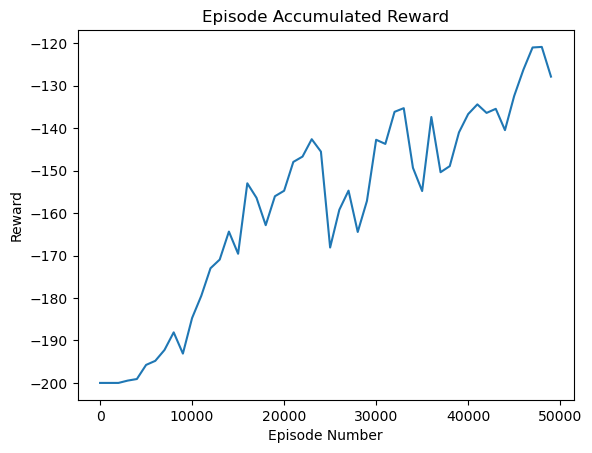

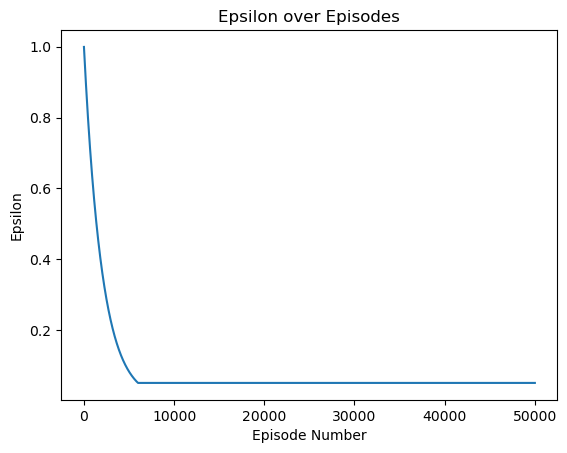

In [30]:
plot_rewards(rewards_ql)
plot_epsilon(epsilons_ql)

In [31]:
env_dis = get_env_discretized(record_video=True, record_every=1, folder="./videos/q_learning_test")

for episode_num in range(5):
    (pos, vel), info = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_ql[pos, vel])  # Exploit
        (pos, vel), reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated

/opt/anaconda3/envs/taller_ia_2025/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/gotero/facultad/2025/taller_ia/laboratorio04/videos/q_learning_test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## SARSA
Sarsa es otro algoritmo de aprendizaje por refuerzo que, a diferencia de Q-Learning, es un método on-policy. Esto significa que el agente actualiza su tabla Q utilizando la acción que realmente toma en el entorno, lo que lo hace más sensible a la política actual. El algoritmo se basa en el siguiente algoritmo:

$$
\begin{aligned}
\textbf{Sarsa (On-Policy TD Control)} \\[6pt]
\textbf{Parámetros:} & \quad \alpha \in (0,1],\ \varepsilon > 0,\ \gamma \in (0,1].\\[6pt]
\textbf{Inicializar:} & \quad Q(s,a)\ \text{arbitrario para } s \in S,\ a \in A(s), \\
& \quad Q(\text{terminal},\cdot) = 0.\\[6pt]
\textbf{Loop (por cada episodio):} & \\[-2pt]
& \quad \text{Inicializar } S \text{ y elegir } A \text{ usando política } \varepsilon\text{-greedy con respecto a } Q.\\
& \quad \textbf{mientras } S \text{ no sea terminal:}\\
& \quad\quad \text{Ejecutar } A,\ \text{observar } R,\ S'.\\
& \quad\quad \text{Elegir } A' \text{ a partir de } S' \text{ usando política } \varepsilon\text{-greedy con respecto a } Q.\\
& \quad\quad Q(S,A) \leftarrow Q(S,A) \;+\; \alpha \Bigl[\,R \;+\; \gamma\,Q(S',A') \;-\; Q(S,A)\Bigr].\\
& \quad\quad S \leftarrow S',\quad A \leftarrow A'.\\
\end{aligned}
$$


In [32]:
def select_action(Q, pos, vel, epsilon):
    """
    Select an action using epsilon-greedy policy.
    
    Args:
        Q (np.ndarray): The Q-table.
        state (tuple): The current state.
        epsilon (float): The exploration rate.
        
    Returns:
        action (int): The selected action.
    """
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(Q[pos][vel])  # Exploit

def sarsa(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon_start=1, epsilon_decay=0.9995, epsilon_min=0.05):
    """
    SARSA algorithm for the MountainCar environment.
    
    Args:
        env (gym.Env): The environment to train on.
        num_episodes (int): Number of episodes to train.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon_start (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for exploration.
        epsilon_min (float): Minimum exploration rate.
        
    Returns:
        Q (np.ndarray): The learned Q-table.
        episode_rewards (list): Rewards per episode.
        epsilons (list): Exploration rates per episode.
    """


    Q = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
    episode_rewards = []
    epsilons = []
    epsilon = epsilon_start
    for episode in tqdm(range(num_episodes)):

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        (pos,vel), _ = env.reset()
        done = False
        total_reward = 0

        action = select_action(Q, pos, vel, epsilon)

        while not done:
            (next_pos, next_vel), reward, terminated, truncated, _ = env.step(action)
            next_action = select_action(Q, next_pos, next_vel, epsilon)
            Q_next_max = Q[next_pos][next_vel][next_action]
            Q[pos][vel][action] += alpha * (reward + gamma * Q_next_max - Q[pos][vel][action])
            done = terminated or truncated
            # Actualizamos el estado pasando al siguiente estado
            pos, vel = next_pos, next_vel
            # Actualizamos la acción pasando a la siguiente acción con epsilon-greedy
            action = next_action
            total_reward += reward


        episode_rewards.append(total_reward)
        epsilons.append(epsilon)

    return Q, episode_rewards, epsilons

In [33]:
env_dis = get_env_discretized(record_video=True, record_every=1_000, folder="./videos/sarsa_training")
Q_sarsa, rewards_sarsa, epsilons_sarsa = sarsa(env_dis, num_episodes=NUMBER_EPISODES)

/opt/anaconda3/envs/taller_ia_2025/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
100%|██████████| 50000/50000 [01:59<00:00, 420.03it/s]


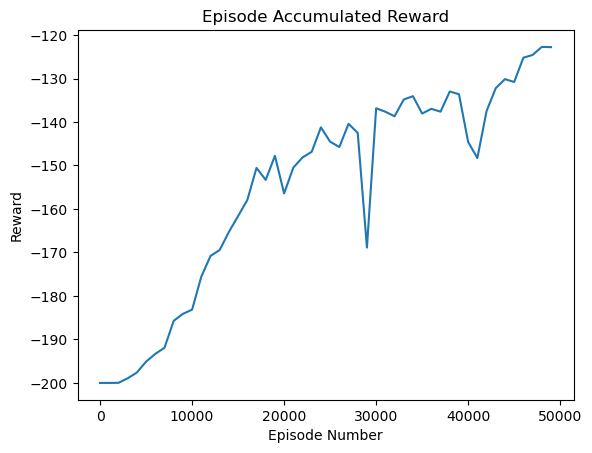

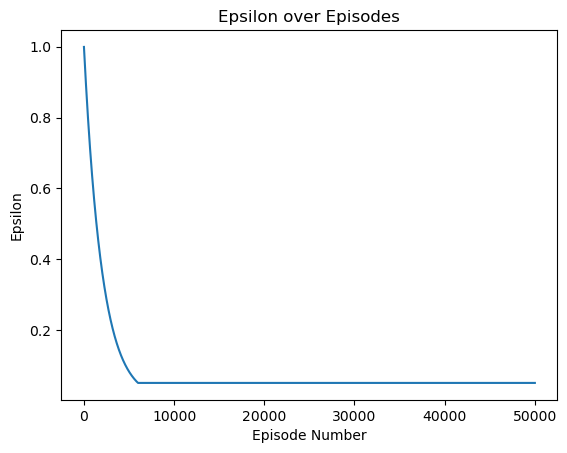

In [34]:
plot_rewards(rewards_sarsa)
plot_epsilon(epsilons_sarsa)

In [35]:
env_dis = get_env_discretized(record_video=True, record_every=1, folder="./videos/sarsa_test")

for episode_num in range(5):
    (pos, vel), info = env_dis.reset()
    episode_over = False
    while not episode_over:
        action = np.argmax(Q_sarsa[pos, vel])  # Exploit
        (pos, vel), reward, terminated, truncated, info = env_dis.step(action)
        episode_over = terminated or truncated

## Tareas

1. Implementar tanto el algoritmo de Q-Learning como el de Sarsa para estimar la función Q de la política definida.
2. Implementar el experimento de Cliff Walking, tal como se describe en el libro, para comparar ambos algoritmos. Analizar y discutir los resultados, en particular, identificar cuál de los dos algoritmos tiende a "caminar por el borde" (tomando más riesgos) y cuál es más cauteloso. Utilizar el entorno [CliffWalking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).